# Agentic RAG System

This notebook implements a reliable Agentic RAG (Retrieval-Augmented Generation) system using LangGraph. The system integrates three key RAG approaches:

1. **Adaptive RAG**: Intelligently routes queries to the most appropriate processing path
2. **Corrective RAG**: Uses web search as a fallback when internal knowledge is insufficient
3. **Self-RAG**: Implements self-correction mechanisms to reduce hallucinations

The system routes queries to one of three paths:
- Direct response (for simple greetings or general knowledge)
- Vectorstore RAG (with document relevance grading and query rewriting retries)
- Web search (as a fallback when RAG fails)

By grading document relevance and implementing fallback mechanisms, the system ensures accurate and reliable answers.

## System Architecture

The Agentic RAG system follows a modular architecture with the following components:

<image src="../resources/agenticrag_1.png">

## 1. Environment Setup

### 1.1 Imports and Dependencies

Import required libraries for the RAG agent, including:
- LangChain for tools, embeddings, and LLM integration
- LangGraph for building stateful agent workflows
- Pydantic for structured data validation
- Standard Python libraries for JSON handling and type annotations

In [1]:
import json
import operator
import requests

from typing import Annotated, TypedDict

from langchain_community.vectorstores import FAISS
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_huggingface import HuggingFaceEmbeddings
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field

# Note: Using local Ollama Qwen model for LLM
from langchain_openai import ChatOpenAI

### 1.2 Agent State Definition

Define the AgentState as a TypedDict to persist state across the LangGraph workflow. This enables stateful agent behavior by maintaining:
- Messages: Conversation history between user and agent
- RAG Retries: Counter for tracking query rewriting attempts

This follows the state management pattern described in the Adaptive RAG tutorial.

In [2]:
# Define Agent State for LangGraph workflow
# This enables stateful agent behavior by maintaining conversation history and retry counts
class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], operator.add]
    rag_retries: int

## 2. Knowledge Base

### 2.1 Vector Store Initialization

Load a pre-built FAISS vector store for semantic search on LLM-related topics. The retriever is configured to return the top 2 most relevant documents, supporting the Adaptive RAG retrieval process.

The vector store contains content from Lilian Weng's blog posts on:
- LLM Agents
- Prompt Engineering
- Adversarial Attacks on LLMs

In [5]:
# Load pre-built FAISS database containing LLM-related content
# The database was created from Lilian Weng's blog posts on LLM topics
db_path = './db/faiss_ilianweng_db'
vector_store = FAISS.load_local(
    folder_path=db_path,
    embeddings=HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5"),
    allow_dangerous_deserialization=True
)

# Configure retriever to return top 2 documents for efficient retrieval
retriever = vector_store.as_retriever(search_kwargs={"k": 2})

## 3. Tools and Integrations

### 3.1 Tool Definitions

Define the tools that enable the agent to interact with external systems:

1. **Web Search Tool**: Uses the Serper API to get real-time internet information
2. **RAG Retrieval Tool**: Retrieves documents from the internal vector store

These tools are dynamically callable within the LangGraph workflow, enabling flexible fallback and retrieval mechanisms.

In [ ]:
# Define schema for web search queries using Pydantic for validation
class SearchQuery(BaseModel):
    query: str = Field(description="Search query for web search")


# Web search tool using Serper API for real-time information retrieval
@tool(args_schema=SearchQuery)
def web_search_tool(query: str):
    """Get real-time Internet information using Serper API"""
    url = "https://google.serper.dev/search"
    payload = json.dumps({
        "q": query,
        "num": 3,  # Retrieve top 3 search results for comprehensive coverage
    })
    headers = {
        'X-API-KEY': 'YOUR_SERPER_API_KEY',
        'Content-Type': 'application/json'
    }
    
    response = requests.post(url, headers=headers, data=payload)
    data = json.loads(response.text)
    if 'organic' in data:
        return json.dumps(data['organic'], ensure_ascii=False)
    else:
        return json.dumps({"error": "No organic results found"}, ensure_ascii=False)


# Define schema for RAG queries using Pydantic for validation
class RagQuery(BaseModel):
    query: str = Field(description="Query for RAG document retrieval")


# RAG retrieval tool for internal document search from vector store
@tool(args_schema=RagQuery)
def rag_retrieval_tool(query: str):
    """
    Retrieves documents from the RAG vector store.
    This tool is the core of the Retrieval-Augmented Generation pipeline.
    """
    # 1. Retrieve relevant documents using the configured FAISS retriever
    documents = retriever.invoke(query)
        
    # 2. Format retrieved documents as a single context string
    doc_contents = "\n\n".join(d.page_content for d in documents)
    return json.dumps({"documents": doc_contents})

### 3.2 LLM Configuration

Configure the ChatOpenAI wrapper to use a local Qwen model via Ollama. The LLM is bound with both tools to enable structured tool calling for:
- Query routing decisions
- Document relevance grading
- Answer generation

Temperature is set to 0.3 for a balance between creativity and consistency.

In [9]:
# Configure LLM with local Qwen model via Ollama for privacy and cost efficiency
llm = ChatOpenAI(
    model_name="qwen3:8b",
    base_url='http://localhost:11434/v1',
    openai_api_key="<KEY>",  # Placeholder key (not used for local models)
    temperature=0.3  # Low temperature for consistent, factual responses
)

# Bind tools for structured tool calling in LangGraph workflow
llm_with_tools = llm.bind_tools([rag_retrieval_tool, web_search_tool])

## 4. Workflow Components

### 4.1 Node Functions

Define the core node functions that implement the Agentic RAG workflow. These functions combine concepts from Adaptive, Corrective, and Self-RAG approaches:

1. **Query Routing**: Determines the best processing path for each query
2. **Document Retrieval**: Fetches relevant documents from the vector store
3. **Document Grading**: Assesses the relevance of retrieved documents
4. **Query Rewriting**: Improves queries when initial retrieval fails
5. **Web Fallback**: Uses web search when RAG approaches fail
6. **Answer Generation**: Produces final responses based on available context

In [22]:
# Route query to direct response, RAG, or web search
def route_query(state: AgentState):
    """
    Routes the user's question to the most appropriate processing path:
    - Direct response (for greetings or general knowledge)
    - RAG pipeline (for LLM-specific topics)
    - Web search (for time-sensitive information)
    
    This function implements the query routing mechanism from Adaptive RAG,
    using LLM-based decisions to determine the optimal processing path.
    """
    print("---ROUTING QUERY---")
    last_message = state["messages"][-1]
    
    # System prompt for query routing decisions
    # Instructs the LLM to classify queries into direct response, RAG, or web search
    system_prompt = """You are a query router. If the question is a simple greeting like 'hello' or can be answered directly without any retrieval or external information, respond with a friendly, concise answer. Otherwise, determine if the question can be answered using internal knowledge (call rag_retrieval_tool with the query) or requires external real-time information (call web_search_tool with the query). Use the vectorstore for questions on LLM agents, prompt engineering, and adversarial attacks. You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use web-search. Do not provide any explanation or reasoning beyond the direct answer if applicable."""
    
    response = llm_with_tools.invoke([SystemMessage(content=system_prompt), last_message])
    print(f"Routing decision: {response.tool_calls if hasattr(response, 'tool_calls') else 'Direct response'}")
    
    tool_calls = response.tool_calls if hasattr(response, 'tool_calls') else []
    if tool_calls:
        # Return tool call for RAG or web search processing
        return {"messages": [AIMessage(content="", tool_calls=tool_calls)], "last_query": tool_calls[0]["args"]["query"]}
    else:
        # Return direct response for simple queries
        return {"messages": [AIMessage(content=response.content)]}

# RAG retrieval node - fetch documents from vector store
def rag_retrieval(state: AgentState):
    """
    Executes the RAG retrieval tool to fetch relevant documents from the vector store.
    
    This function is part of the Retrieval-Augmented Generation pipeline and
    implements the document retrieval step from the RAG approach.
    """
    print("---RETRIEVING DOCUMENTS FROM RAG---")
    last_message = state["messages"][-1]
    query = last_message.tool_calls[0]["args"]["query"]
    
    # Invoke the RAG retrieval tool with the query
    result = rag_retrieval_tool.invoke({"query": query})
    doc_content = json.loads(result)["documents"]
    
    # Return retrieved documents as a tool message
    return {"messages": [ToolMessage(content=doc_content, tool_call_id=last_message.tool_calls[0]["id"])]}

# Grade RAG documents for relevance
def grade_rag_documents(state: AgentState):
    """
    Grades the relevance of retrieved documents to determine if they can answer the user's question.
    Returns 'Documents relevant' or 'Documents not relevant' based on LLM assessment.
    
    This function implements the document grading mechanism from Self-RAG,
    which helps reduce hallucinations by ensuring document relevance before generation.
    """
    print("---GRADING RAG DOCUMENTS---")
    last_message = state["messages"][-1]
    question = state["messages"][0].content
    
    # Handle case where no documents were retrieved
    if not last_message.content:
        print("No documents retrieved, grading as irrelevant.")
        return {"messages": [AIMessage(content="Documents not relevant.")], "rag_retries": state.get("rag_retries", 0) + 1}

    # Prompt LLM to grade document relevance
    # Uses a focused prompt that requires only 'yes' or 'no' response
    grading_prompt = f"""You are a grader assessing the relevance of retrieved documents to a user question.
    User question: {question}
    Retrieved documents:
    ---
    {last_message.content}
    ---
    Are the documents relevant to the question? Respond with 'yes' or 'no' only, nothing else."""
    
    response = llm.invoke([HumanMessage(content=grading_prompt)])
    is_relevant = 'yes' in response.content.lower()
    print(f"Grading decision: {is_relevant}")
    
    if is_relevant:
        # Documents are relevant, reset retry counter and proceed to generation
        return {"messages": [AIMessage(content="Documents relevant.")], "rag_retries": 0}
    else:
        # Documents are not relevant, increment retry counter
        return {"messages": [AIMessage(content="Documents not relevant.")], "rag_retries": state.get("rag_retries", 0) + 1}

# Rewrite RAG query when initial retrieval fails
def rewrite_query(state: AgentState):
    """
    Rewrites the query to improve retrieval performance when the first attempt failed.
    Implements the query rewriting mechanism from Adaptive RAG.
    """
    print("---REWRITING RAG QUERY---")
    question = state["messages"][0].content
    
    # Prompt LLM to generate a better query
    rewrite_prompt = f"""You are a query rewriting expert. The user's original question is: "{question}".
    This query will be used to retrieve documents from a vector database. Please generate a better, more specific query.
    Do not think step-by-step or add any explanations. Respond with the rewritten query only, nothing else."""
    
    response = llm.invoke([HumanMessage(content=rewrite_prompt)])
    rewritten_query = response.content.strip()
    
    # Clean up potential markdown code block artifacts
    if '```' in rewritten_query:
        rewritten_query = rewritten_query.split('```', 1)[-1].strip()
    
    if rewritten_query:
        print(f"Rewritten query: {rewritten_query}")
        tool_call = {"name": "rag_retrieval_tool", "args": {"query": rewritten_query}, "id": "call_" + str(hash(rewritten_query))[:8], "type": "tool_call"}
        return {"messages": [AIMessage(content="", tool_calls=[tool_call])]}
    else:
        print("No rewritten query generated, using original question.")
        tool_call = {"name": "rag_retrieval_tool", "args": {"query": question}, "id": "call_" + str(hash(question))[:8], "type": "tool_call"}
        return {"messages": [AIMessage(content="", tool_calls=[tool_call])]}

# Fallback to web search after max RAG retries
def fallback_to_web_search(state: AgentState):
    """
    Prepares a tool call for web search when RAG approaches have failed after maximum retries.
    Implements the Corrective RAG fallback mechanism.
    """
    print("---FALLING BACK TO WEB SEARCH---")
    query = state["messages"][0].content
    
    tool_call = {"name": "web_search_tool", "args": {"query": query}, "id": "call_" + str(hash(query))[:8], "type": "tool_call"}
    return {"messages": [AIMessage(content="", tool_calls=[tool_call])]}

# Execute web search using Serper API
def web_search(state: AgentState):
    """
    Performs a web search using the Serper API to get real-time information.
    This is part of the Corrective RAG fallback mechanism.
    """
    print("---PERFORMING WEB SEARCH---")
    last_message = state["messages"][-1]
    query = last_message.tool_calls[0]["args"]["query"]
    
    search_results = web_search_tool.invoke({"query": query})
    return {"messages": [ToolMessage(content=search_results, tool_call_id=last_message.tool_calls[0]["id"])]}

# Generate final answer based on context
def generate_answer(state: AgentState):
    """
    Generates a final answer based on the retrieved context (from RAG or web search).
    This function produces the final user-facing response.
    """
    print("---GENERATING FINAL ANSWER---")
    question = state["messages"][0].content
    # Find the actual context (from RAG retrieval or web search)
    # The context is in the ToolMessage, which should be before the grading message
    context = ""
    messages = state["messages"]
    for i in range(len(messages) - 1, -1, -1):
        if isinstance(messages[i], ToolMessage):
            context = messages[i].content
            break
        # If we find the "Documents relevant" message, the context is in the previous ToolMessage
        elif isinstance(messages[i], AIMessage) and "Documents relevant" in messages[i].content:
            # Look for the ToolMessage before this grading message
            for j in range(i - 1, -1, -1):
                if isinstance(messages[j], ToolMessage):
                    context = messages[j].content
                    break
            break
    
    # Prompt LLM to generate answer using context
    generation_prompt = f"""You are an expert assistant. Use the following retrieved context to answer the user's question.
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    Question: {question}
    Context:
    {context}
    ---
    Answer:
    """
    
    response = llm.invoke([HumanMessage(content=generation_prompt)])
    return {"messages": [AIMessage(content=response.content)]}

# Define conditional routing logic
def get_route(state: AgentState):
    """
    Determines the next node based on the routing decision.
    This function implements the conditional routing logic in the LangGraph workflow.
    """
    last_msg = state["messages"][-1]
    if not last_msg.tool_calls:
        return "__end__"
    tool_name = last_msg.tool_calls[0]["name"]
    if tool_name == "rag_retrieval_tool":
        return "rag_retrieval"
    elif tool_name == "web_search_tool":
        return "web_search"
    else:
        return "__end__"

# Adaptive RAG routing logic
def should_retry_rag(state: AgentState):
    """
    Implements the Adaptive RAG decision logic:
    - If documents are relevant → generate answer
    - If retries < 3 → rewrite query
    - If retries >= 3 → fallback to web search
    
    This function enables the self-correcting behavior of the RAG system.
    """
    last_message = state["messages"][-1]
    if "Documents relevant." in last_message.content:
        return "generate"
    else:
        if state.get("rag_retries", 0) >= 3:
            return "fallback_to_web_search"
        else:
            return "rewrite"

## 5. Workflow Orchestration

### 5.1 Graph Construction

Build the LangGraph workflow by connecting all nodes with appropriate edges and conditional routing. This creates a stateful agent that can:
- Dynamically route queries based on content
- Retry RAG retrieval with query rewriting
- Fallback to web search when needed
- Generate final answers from retrieved context

The graph implements the reliable RAG agent guide and Adaptive RAG tutorial patterns.

In [24]:
# Initialize LangGraph workflow
# This creates a stateful agent that can maintain conversation context and retry logic
workflow = StateGraph(AgentState)

# Add all nodes to the workflow
workflow.add_node("route_query", route_query)
workflow.add_node("rag_retrieval", rag_retrieval)
workflow.add_node("grade_rag_documents", grade_rag_documents)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("fallback_to_web_search", fallback_to_web_search)
workflow.add_node("web_search", web_search)
workflow.add_node("generate_answer", generate_answer)

# Set entry point for the workflow
workflow.set_entry_point("route_query")

# Add edges and conditional routing
workflow.add_conditional_edges(
    "route_query",
    get_route,
    {
        "rag_retrieval": "rag_retrieval",
        "web_search": "web_search",
        "__end__": END
    }
)

workflow.add_edge("rag_retrieval", "grade_rag_documents")
workflow.add_conditional_edges(
    "grade_rag_documents",
    should_retry_rag,
    {
        "generate": "generate_answer",
        "rewrite": "rewrite_query",
        "fallback_to_web_search": "fallback_to_web_search",
    }
)
workflow.add_edge("rewrite_query", "rag_retrieval")
workflow.add_edge("fallback_to_web_search", "web_search")
workflow.add_edge("web_search", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile the graph into an executable workflow
graph = workflow.compile()

### 5.2 Workflow Visualization

Display a diagram of the LangGraph workflow to visualize the agent's decision process.

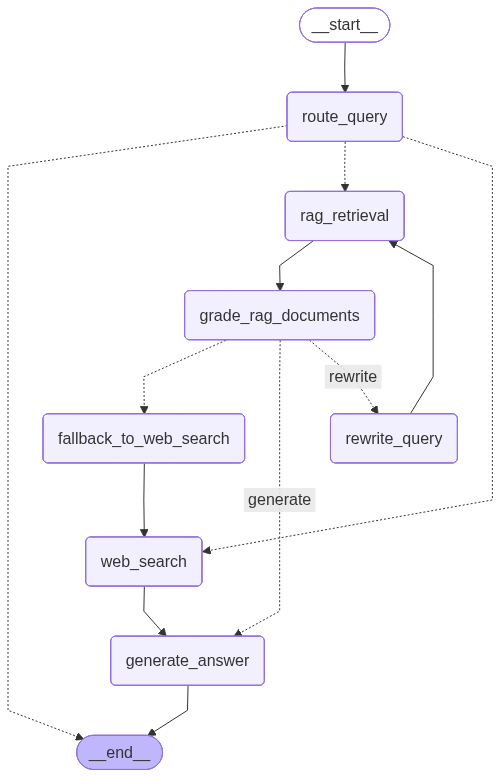

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 6. Testing and Validation

### 6.1 System Testing

Test the graph with sample queries to verify that routing, retrieval, grading, and generation work as intended in the reliable RAG setup. Uncomment different test queries to try various scenarios:

- Simple greetings
- LLM-specific questions (uses RAG)
- Time-sensitive questions (uses web search)
- Complex questions requiring multiple retries

In [26]:
# Test queries - uncomment to try different scenarios
# question = "hello"  # Simple greeting - direct response
# question = "What is LLM Agent?"  # LLM topic - RAG retrieval
# question = "Describe most recent event of OpenAI"  # Time-sensitive - web search
question = "What does Lilian Weng say about types of reward hacking?"  # Complex query - full RAG workflow

# Initialize state for the workflow
initial_state = {"messages": [HumanMessage(content=question)], "rag_retries": 0}

# Stream the workflow execution and display outputs
for event in graph.stream(initial_state, {"recursion_limit": 25}):
    for key, value in event.items():
        print(f"--- Output from node '{key}' ---")
        print(value)
        print("\n---\n")

---ROUTING QUERY---
Routing decision: [{'name': 'rag_retrieval_tool', 'args': {'query': 'What does Lilian Weng say about types of reward hacking?'}, 'id': 'call_254y79yw', 'type': 'tool_call'}]
--- Output from node 'route_query' ---
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'rag_retrieval_tool', 'args': {'query': 'What does Lilian Weng say about types of reward hacking?'}, 'id': 'call_254y79yw', 'type': 'tool_call'}])]}

---

---RETRIEVING DOCUMENTS FROM RAG---
--- Output from node 'rag_retrieval' ---
{'messages': [ToolMessage(content="Adversarial Attacks on LLMs | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Adversarial Attacks on LLMs\n    \nDate: October 25, 2023  |  Estimated Reading Time: 33 min  |  Author: Lilian Weng\n\n\n \n\n\nTabl

### 6.2 Knowledge Base Management

Code to rebuild the FAISS vector database from source documents. This section:
1. Loads content from Lilian Weng's blog posts
2. Splits documents into chunks
3. Generates embeddings using HuggingFace
4. Creates and saves the FAISS index

Run this section when you need to update the knowledge base.

In [4]:
import os

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Source URLs for LLM-related content
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
print(f"len of documents :{len(docs_list)}")

# Split documents into chunks for better retrieval
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
print(f"length of document chunks generated :{len(doc_splits)}")

# Create and save FAISS vector database
db_path = './db/faiss_ilianweng_db'
vector_db = FAISS.from_documents(doc_splits, HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5"),)
        
# Save database to disk
os.makedirs(os.path.split(db_path)[0], exist_ok=True)
vector_db.save_local(db_path)
print(f"\nDatabase update complete! Total chunks: {vector_db.index.ntotal}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


len of documents :3
length of document chunks generated :87

Database update complete! Total chunks: 87
